### Notebook information

This notebook focuses on data loading, cleaning, and basic preprocessing using Python (Pandas). 

The data originates from a real industrial test environment at SmartFactoryOWL (Fraunhofer IOSB-INA).
It represents binary signals from sensors and actuators within a storage module, which is part of a modular and automated production system.
These signals reflect the operation of components such as a funnel, silo, aspirator, and pneumatic actuators.

### 1. Load Libraries 

In [34]:
import pandas as pd 
from IPython.display import display
import os 

import matplotlib.pyplot as plt
import seaborn as sns   

In [19]:
os.listdir('../01_RawData')

['Deliverymodule.csv',
 'Dosingmodule.csv',
 'Filling_ALL.module.csv',
 'Filling_CapGrabber.module.csv',
 'Filling_CapScrewer.module.csv',
 'Filling_CornPortioning.module.csv',
 'Filling_Pump.module.csv',
 'Production.csv',
 'Storagemodule.csv']

In [28]:
path_storagemodele = '../01_RawData/Storagemodule.csv'
df_storage = pd.read_csv(path_storagemodele, sep=',')


#### 2. Column Descriptions 

The dataset consists of binary sensor and actuator signals captured from a storage module in a manufacturing system.  
Below is a brief description of each column:

- `Timestamp` – Time of signal capture (likely in milliseconds since Unix epoch)
- `FunnelBlocked.I_xSignal` – Sensor indicating if the funnel is blocked
- `StorageSiloFull.I_xSignal` – Sensor indicating the storage silo is full
- `StorageSiloMinFull.I_xSignal` – Sensor indicating the silo is above minimum level
- `Aspirator.O_xOn` – Actuator signal: aspirator is running
- `MuscleTrigger.O_xOn` – Output trigger to activate pneumatic system
- `MuscleTrigger.xOn` – Internal control trigger for muscle system activation

In [29]:
df_storage['Timestamp'] = pd.to_datetime(df_storage['Timestamp'], unit='ms')

df_storage.sort_values(by='Timestamp', inplace=True, ascending=True)

df_storage.head(10)

,Timestamp,FunnelBlocked.I_xSignal,StorageSiloFull.I_xSignal,StorageSiloMinFull.I_xSignal,Aspirator.O_xOn,MuscleTrigger.O_xOn,MuscleTrigger.xOn
0,2018-01-05 13:08:16.228,0,1,1,0,0,0
1,2018-01-05 13:08:16.329,0,1,1,0,0,0
2,2018-01-05 13:08:16.429,0,1,1,0,0,0
3,2018-01-05 13:08:16.529,0,1,1,0,0,0
4,2018-01-05 13:08:16.629,0,1,1,0,0,0
5,2018-01-05 13:08:16.729,0,1,1,0,0,0
6,2018-01-05 13:08:16.829,0,1,1,0,0,0
7,2018-01-05 13:08:16.929,0,1,1,0,0,0
8,2018-01-05 13:08:17.030,0,1,1,0,0,0
9,2018-01-05 13:08:17.130,0,1,1,0,0,0


In [30]:
# Krok 1 – wybierz kolumny binarne (oprócz Timestamp)
binary_cols = df_storage.columns.drop('Timestamp')

# Krok 2 – policz liczbę aktywnych sygnałów (czy coś działa)
df_storage['ActiveSignals'] = df_storage[binary_cols].sum(axis=1)

# Krok 3 – stwórz flagę: 1 = idle (czyli nic nie działa), 0 = aktywność
df_storage['IsIdle'] = (df_storage['ActiveSignals'] == 0).astype(int)

# Krok 4 – oblicz różnicę czasu między kolejnymi rekordami (sekundy)
df_storage['DeltaTime'] = df_storage['Timestamp'].diff().dt.total_seconds()

df_storage[['Timestamp', 'ActiveSignals', 'IsIdle', 'DeltaTime']].head(10)

,Timestamp,ActiveSignals,IsIdle,DeltaTime
0,2018-01-05 13:08:16.228,2,0,NaN
1,2018-01-05 13:08:16.329,2,0,0.101
2,2018-01-05 13:08:16.429,2,0,0.100
3,2018-01-05 13:08:16.529,2,0,0.100
4,2018-01-05 13:08:16.629,2,0,0.100
5,2018-01-05 13:08:16.729,2,0,0.100
6,2018-01-05 13:08:16.829,2,0,0.100
7,2018-01-05 13:08:16.929,2,0,0.100
8,2018-01-05 13:08:17.030,2,0,0.101
9,2018-01-05 13:08:17.130,2,0,0.100


#### 3. Check NULL values in datase

In [31]:
df_storage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11957 entries, 0 to 11956
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Timestamp                     11957 non-null  datetime64[ns]
 1   FunnelBlocked.I_xSignal       11957 non-null  int64         
 2   StorageSiloFull.I_xSignal     11957 non-null  int64         
 3   StorageSiloMinFull.I_xSignal  11957 non-null  int64         
 4   Aspirator.O_xOn               11957 non-null  int64         
 5   MuscleTrigger.O_xOn           11957 non-null  int64         
 6   MuscleTrigger.xOn             11957 non-null  int64         
 7   ActiveSignals                 11957 non-null  int64         
 8   IsIdle                        11957 non-null  int32         
 9   DeltaTime                     11956 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(7)
memory usage: 887.6 KB


After checking the dataset using `.info()`, I confirmed that there are no missing values.

That's great, because it means I don't need to apply any imputation or filling techniques.  
Filling missing values always carries the risk of introducing artificial or incorrect data into the analysis — which may mislead the model or distort the patterns.

This gives me more confidence in the quality and completeness of the dataset before moving forward.

#### 4.Statistic check dataset - identify outliers 

4.1. Basic statistics

In [ ]:
df_storage.describe().T

,count,mean,min,25%,50%,75%,max,std
Timestamp,11957,2018-01-05 13:18:15.030550784,2018-01-05 13:08:16.228000,2018-01-05 13:13:15.567000064,2018-01-05 13:18:14.953999872,2018-01-05 13:23:14.473999872,2018-01-05 13:28:14.166000,NaN
FunnelBlocked.I_xSignal,11957.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
StorageSiloFull.I_xSignal,11957.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
StorageSiloMinFull.I_xSignal,11957.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Aspirator.O_xOn,11957.0,0.077779,0.0,0.0,0.0,0.0,1.0,0.267834
MuscleTrigger.O_xOn,11957.0,0.011792,0.0,0.0,0.0,0.0,1.0,0.107954
MuscleTrigger.xOn,11957.0,0.032115,0.0,0.0,0.0,0.0,1.0,0.176313
ActiveSignals,11957.0,2.121686,2.0,2.0,2.0,2.0,5.0,0.467043
IsIdle,11957.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DeltaTime,11956.0,0.100196,0.1,0.1,0.1,0.1,0.135,0.000619


4.2. Histogram of `DeltaTime` distribution

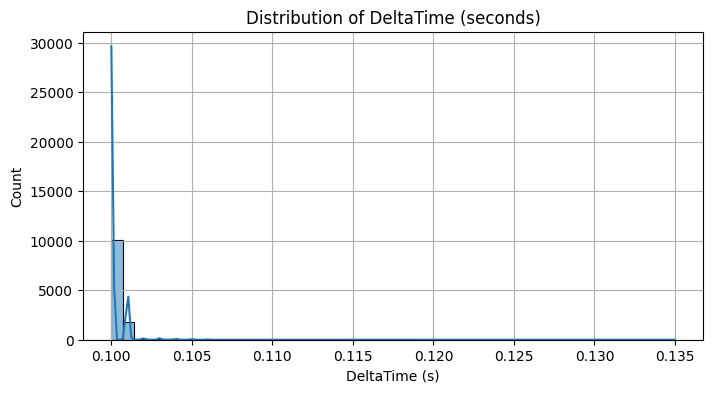

In [38]:
plt.figure(figsize=(8, 4))
sns.histplot(df_storage['DeltaTime'], bins=50, kde=True)
plt.title('Distribution of DeltaTime (seconds)')
plt.xlabel('DeltaTime (s)')
plt.ylabel('Count')
plt.grid()
plt.show()

W większości przypadków DeltaTime ≈ 0.100s, czyli dane są rejestrowane z częstotliwością co 100 ms.
<br>
Wartości powyżej ~0.102 s mogą wskazywać na opóźnienia systemowe, problem z komunikacją lub przerwę w działaniu — warto je oznaczyć jako outliery lub anomalie czasowe.

Wniosek: można stworzyć flagę isTimingAnomaly = DeltaTime > 0.102

4.3. Histogram of `ActiveSignals` distibution

Text(0.5, 1.0, 'Number of Active Signals per Record')

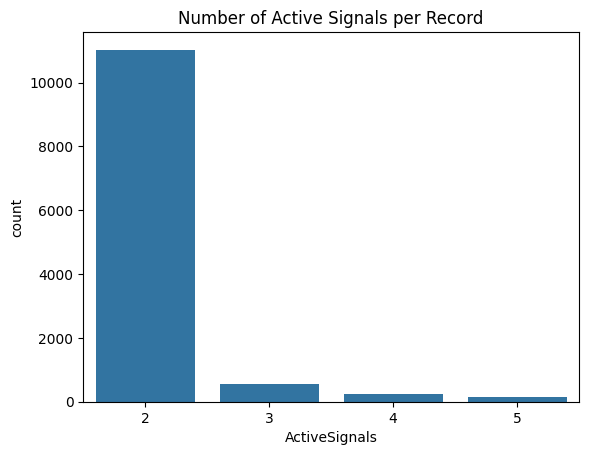

In [39]:
sns.countplot(x='ActiveSignals', data=df_storage)
plt.title('Number of Active Signals per Record')

Najczęstsza wartość to 2, co sugeruje, że w danym momencie zawsze działa równolegle co najmniej 2 sygnały.
<br>
Brak 1 może oznaczać, że system nie działa w pojedynczych stanach — zawsze jakiś duet sygnałów.
<br>
Wartości 3, 4, 5 mogą wskazywać na nienaturalnie równoległą aktywność — być może sytuację problemową, np. zator, nadmierną presję, awarię zaworu.

Wniosek: można potraktować ActiveSignals > 2 jako wzór do badania potencjalnej blokady / błędu sekwencji

4.4. Active signals vs Time

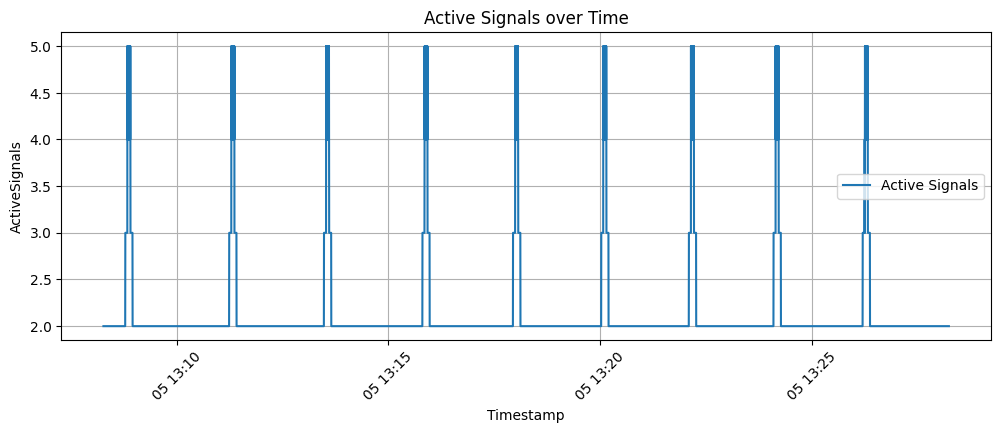

In [42]:
plt.figure(figsize=(12, 4))
plt.plot(df_storage['Timestamp'], df_storage['ActiveSignals'], label='Active Signals')
plt.title('Active Signals over Time')
plt.xlabel('Timestamp')
plt.ylabel('ActiveSignals')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

Na wykresie widać „piki” sięgające 5 — to momenty, w których wiele sygnałów było aktywnych równocześnie.
<br>
Między tymi pikami – sygnał wraca do poziomu 2 (czyli normalna praca?).
<br>
Skokowy charakter może świadczyć o precyzyjnie zsynchronizowanych cyklach — czyli że urządzenie pracuje w zaprogramowanych oknach czasowych.

Wniosek: warto oznaczyć te piki jako potencjalne „momenty cykli” i porównać z Idle

4.5. IsIdle w czasie – przestoje

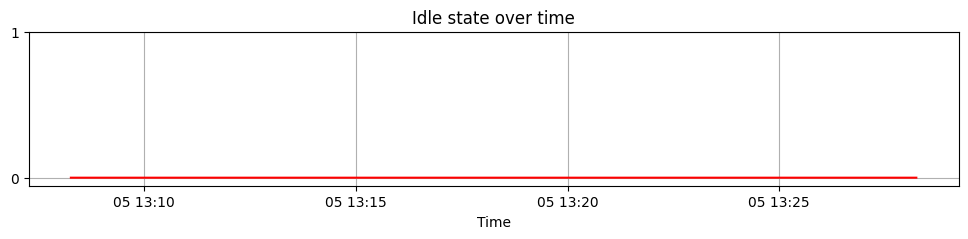

In [43]:
plt.figure(figsize=(12, 2))
plt.plot(df_storage['Timestamp'], df_storage['IsIdle'], color='red', label='IsIdle')
plt.title('Idle state over time')
plt.xlabel('Time')
plt.yticks([0, 1])
plt.grid()
plt.show()

Zgodnie z założeniem, IsIdle = 1 występuje tylko wtedy, gdy ActiveSignals == 0.
<br>
Tutaj widać tylko pojedyncze, krótkie przestoje — czyli maszyna działa niemal cały czas.

Wniosek: brak przestojów to pozytywny sygnał, ale warto przyjrzeć się tym nielicznym momentom Idle=1 — mogą coś sygnalizować (przejście między cyklami?).

4.6. Heatmapa korelacji

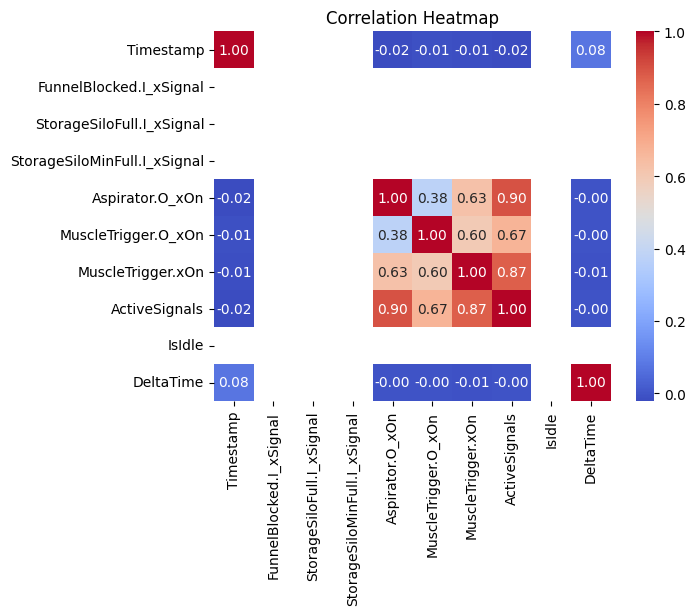

In [44]:
sns.heatmap(df_storage.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Wyraźna korelacja między MuscleTrigger.O_xOn, MuscleTrigger.xOn i Aspirator.O_xOn
<br>
To może wskazywać na cykliczne działanie zespołu: aspirator + siłownik — np. aspirator ssie, potem aktywuje się siłownik, potem reset.
<br>
Korelacja ~0.9 oznacza bardzo silną zależność, czyli sygnały często aktywują się razem.

Wniosek: można wykorzystać te zależności jako cechy do modelu ML (np. triggered_together = 1), lub do logicznego wykrywania niespójnych sekwencji.

#### 3. First analytc data

In [ ]:
df_storage.describe().T

In [ ]:
df_storage.head(10)